#🛠 Preliminary Operation

## Drive

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [ ]:
import h5py
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics

In [ ]:
# Tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Keras

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Embedding, Bidirectional, GRU, LSTM, SpatialDropout1D, Dropout
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, Conv1D, GlobalMaxPool1D, GlobalAveragePooling1D, SpatialDropout1D, Concatenate, Flatten, Convolution1D, MaxPool1D, MaxPooling1D, BatchNormalization

# Tokenization
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

keras.utils.set_random_seed(42)
precision_metric = Precision()
recall_metric = Recall()
auc_metric = AUC()

#💾 Dataset

## Read .hdf5

In [ ]:
train_h5 = h5py.File("/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/VDISC_train.hdf5",'r')
val_h5 = h5py.File("/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/VDISC_validate.hdf5",'r')
test_h5 = h5py.File("/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/VDISC_test.hdf5",'r')

In [ ]:
train_h5.visit(print)

## Train Dataframe

In [ ]:
train_df = pd.DataFrame(list(train_h5['functionSource']))

train_df['CWE-119']=list(train_h5['CWE-119']);
train_df['CWE-120']=list(train_h5['CWE-120']);
train_df['CWE-469']=list(train_h5['CWE-469']);
train_df['CWE-476']=list(train_h5['CWE-476']);
train_df['CWE-other']=list(train_h5['CWE-other'])

In [ ]:
train_df.rename(columns={0:'functionSource'}, inplace=True)

train_df['functionSource'] = train_df['functionSource'].str.decode('utf-8')

train_df.to_pickle("/content/drive/My Drive/Sicurezza_approfondimento/OSF/VDISC_train.pickle")

## Validation Dataframe

In [ ]:
val_df = pd.DataFrame(list(val_h5['functionSource']))

val_df['CWE-119']=list(val_h5['CWE-119']);
val_df['CWE-120']=list(val_h5['CWE-120']);
val_df['CWE-469']=list(val_h5['CWE-469']);
val_df['CWE-476']=list(val_h5['CWE-476']);
val_df['CWE-other']=list(val_h5['CWE-other'])

In [ ]:
val_df.rename(columns={0:'functionSource'}, inplace=True)
val_df['functionSource'] = val_df['functionSource'].str.decode('utf-8')
val_df.to_pickle("/content/drive/My Drive/Sicurezza_approfondimento/OSF/VDISC_validate.pickle")

In [ ]:
val_df

## Test Dataframe

In [ ]:
test_df = pd.DataFrame(list(test_h5['functionSource']))

test_df['CWE-119']=list(test_h5['CWE-119']);
test_df['CWE-120']=list(test_h5['CWE-120']);
test_df['CWE-469']=list(test_h5['CWE-469']);
test_df['CWE-476']=list(test_h5['CWE-476']);
test_df['CWE-other']=list(test_h5['CWE-other'])

In [ ]:
test_df['functionSource'] = test_df['functionSource'].str.decode('utf-8')

In [ ]:
test_df.rename(columns={0:'functionSource'}, inplace=True)

In [ ]:
test_df.to_pickle("/content/drive/My Drive/Sicurezza_approfondimento/OSF/VDISC_test.pickle")

#🗣 Tokenization

In [ ]:
WORDS_SIZE=10000
INPUT_SIZE=200

## Import processed pickle

In [ ]:
train = pd.read_pickle("/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/VDISC_train.pickle")
validate = pd.read_pickle("/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/VDISC_validate.pickle")
test = pd.read_pickle("/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/VDISC_test.pickle")

In [ ]:
train

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True
...,...,...,...,...,...,...
1019466,visitICmpInst(ICmpInst &I) {\n // We must cas...,False,False,False,False,False
1019467,path_node_delete_chain(path_node * head)\n{\n ...,False,False,False,False,False
1019468,addrconf6_start (NMDevice *self)\n{\n\tNMDevic...,False,False,False,False,False
1019469,"Next(const SQObjectPtr &refpos, SQObjectPtr &o...",False,False,False,False,False


## Tokenization process

In [ ]:
# Tokenizer with word-level
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(train['functionSource']))

### Check sequence length

In [ ]:
code_lengths = train['functionSource'].apply(len)
print(code_lengths.describe())

plt.hist(code_lengths, bins=500, alpha = 0.75)
plt.xlabel('Lunghezza codice')
plt.ylabel('Frequenza')
plt.title('Distribuzione lunghezze codici')
plt.show()

### Check distribution

In [ ]:
x = train.iloc[:,2:].sum()
print(x)

In [ ]:
rowsums = train.iloc[:,2:].sum(axis=1)
train['non_vulnerable']=(rowsums==0)
train['non_vulnerable'].sum()
print("Total code = ", len(train))
print("Total non vulnerable code = ", train['non_vulnerable'].sum())

In [ ]:
# Calcola il numero di esempi per label
label_counts = train.iloc[:, 2:].sum()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'gold']

# Crea un grafico a barre con colori diversi e sfondo bianco
plt.figure(figsize=(15, 6))
ax = label_counts.plot(kind='bar', color=colors, fontsize=14)
ax.set_facecolor('white')  # Sfondo bianco
plt.xlabel('Label', fontsize=14)
plt.ylabel('Numero di commenti', fontsize=14)

# Aggiungi etichette con il numero di esempi sopra le barre
for i, v in enumerate(label_counts):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=12, color='black')


plt.show()

In [ ]:
# Calcola il numero di tag per ogni commento
x = rowsums.value_counts()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'gold']

# Crea un grafico a barre per visualizzare il numero di commenti con un numero specifico di tag
plt.figure(figsize=(15, 6))
ax = x.plot(kind='bar', color=colors, fontsize=14)
ax.set_facecolor('white')  # Sfondo bianco
plt.xlabel('Numero di Tag', fontsize=14)  # Imposta la dimensione del font
plt.ylabel('Numero di Commenti', fontsize=14)  # Imposta la dimensione del font

rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)  # Imposta la dimensione del font

plt.show()

### Check words

In [ ]:
print('Number of tokens: ', len(tokenizer.word_counts))

In [ ]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

## Create Sequence

### Train

In [ ]:
## Tokkenizing train data and create matrix
train_sequences = tokenizer.texts_to_sequences(train['functionSource'])
x_train = pad_sequences(train_sequences, maxlen=INPUT_SIZE, padding='post')
x_train = x_train.astype(np.int64)

In [ ]:
# Salva per future esecuzioni
np.save('/content/drive/My Drive/Sicurezza_approfondimento/OSF/x_train_full_500.npy', x_train)

### Validation

In [ ]:
## Tokkenizing train data and create matrix
val_sequences = tokenizer.texts_to_sequences(validate['functionSource'])
x_val = pad_sequences(val_sequences, maxlen=INPUT_SIZE, padding='post')
x_val = x_val.astype(np.int64)

In [ ]:
# Salva per future esecuzioni
np.save('/content/drive/My Drive/Sicurezza_approfondimento/OSF/x_val_full_500.npy', x_val)

### Test

In [ ]:
## Tokkenizing train data and create matrix
test_sequences = tokenizer.texts_to_sequences(test['functionSource'])
x_test = pad_sequences(test_sequences, maxlen=INPUT_SIZE, padding='post')
x_test = x_test.astype(np.int64)

In [ ]:
# Salva per future esecuzioni
np.save('/content/drive/My Drive/Sicurezza_approfondimento/OSF/x_test_full_500.npy', x_test)

## Import sequence

In [ ]:
x_train = np.load('/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/x_train_full_200.npy')
x_val = np.load('/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/x_val_full_200.npy')
x_test = np.load('/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/x_test_full_200.npy')

#✅ Labels and One-Hot-Encoding

In [ ]:
for dataset in [train, validate, test]:
    for col in range(1,6):
        dataset.iloc[:,col] = dataset.iloc[:,col].map({False: 0, True: 1})

label_columns = ['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other']

In [ ]:
train

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",0,0,0,0,0
1,ReconstructDuList(Statement* head)\n{\n Sta...,0,0,0,0,0
2,free_speaker(void)\n{\n if(Lengths)\n ...,0,0,0,0,0
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,0,0,0,0,0
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",1,1,0,0,1
...,...,...,...,...,...,...
1019466,visitICmpInst(ICmpInst &I) {\n // We must cas...,0,0,0,0,0
1019467,path_node_delete_chain(path_node * head)\n{\n ...,0,0,0,0,0
1019468,addrconf6_start (NMDevice *self)\n{\n\tNMDevic...,0,0,0,0,0
1019469,"Next(const SQObjectPtr &refpos, SQObjectPtr &o...",0,0,0,0,0


In [ ]:
y_train=[]
y_val=[]
y_test=[]

#for dataset in [train, validate, test]:
for col in range(1,6):
    #dataset.iloc[:,col] = dataset.iloc[:,col].map({False: 0, True: 1})
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=2).astype(np.int64))
    y_val.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=2).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=2).astype(np.int64))

#🧠 Model - CNN

In [ ]:
check_path_CNN = '/content/drive/My Drive/Sicurezza_approfondimento/Model/1_CNN/Best_Model/best_CNN_unimb.h5'

## Model

In [ ]:
random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [ ]:
# Must use non-sequential model building to create branches in the output layer
inp_layer = Input(shape=(INPUT_SIZE,))
mid_layers = Embedding(input_dim = WORDS_SIZE,
                       output_dim = 13,
                       weights=[random_weights],
                       input_length = INPUT_SIZE)(inp_layer)
mid_layers = Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(mid_layers)
mid_layers = MaxPool1D(pool_size=5)(mid_layers)
mid_layers = Dropout(0.5)(mid_layers)
mid_layers = Flatten()(mid_layers)
mid_layers = Dense(64, activation='relu')(mid_layers)
mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
output1 = Dense(2, activation='softmax')(mid_layers)
output2 = Dense(2, activation='softmax')(mid_layers)
output3 = Dense(2, activation='softmax')(mid_layers)
output4 = Dense(2, activation='softmax')(mid_layers)
output5 = Dense(2, activation='softmax')(mid_layers)

model_cnn = Model(inp_layer, [output1, output2, output3, output4, output5])

model_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 13)              130000    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 200, 512)             60416     ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 40, 512)              0         ['conv1d[0][0]']              
 D)                                                                                           

In [ ]:
## Compile model with metrics
adam = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False)

## Compile model with metrics
model_cnn.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision_metric, recall_metric, auc_metric])

## Training

In [ ]:
checkpoint = ModelCheckpoint(check_path_CNN, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="auto", restore_best_weights=True, start_from_epoch=5,
)
callbacks_list = [checkpoint, early_stopping]

class_weights = [{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.}]

In [ ]:
history = model_cnn.fit(
    x = x_train,
    y = [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
    validation_data = (x_val, [y_val[0], y_val[1], y_val[2], y_val[3], y_val[4]]),
    batch_size = 1024,
    epochs = 50,
    callbacks = callbacks_list,
    #class_weight = class_weights,
    )

Epoch 1/50
996/996 [==============================] - ETA: 0s - loss: 0.3413 - dense_2_loss: 0.0685 - dense_3_loss: 0.1107 - dense_4_loss: 0.0128 - dense_5_loss: 0.0471 - dense_6_loss: 0.1022 - dense_2_accuracy: 0.9807 - dense_2_precision: 0.9807 - dense_2_recall: 0.9807 - dense_2_auc: 0.9955 - dense_3_accuracy: 0.9615 - dense_3_precision: 0.9615 - dense_3_recall: 0.9615 - dense_3_auc: 0.9911 - dense_4_accuracy: 0.9976 - dense_4_precision: 0.9976 - dense_4_recall: 0.9976 - dense_4_auc: 0.9992 - dense_5_accuracy: 0.9899 - dense_5_precision: 0.9899 - dense_5_recall: 0.9899 - dense_5_auc: 0.9955 - dense_6_accuracy: 0.9717 - dense_6_precision: 0.9717 - dense_6_recall: 0.9717 - dense_6_auc: 0.9901
Epoch 1: val_loss improved from inf to 0.31540, saving model to /content/drive/My Drive/Sicurezza_approfondimento/Model/1_CNN/Best_Model/best_CNN_unimb.h5
996/996 [==============================] - 186s 175ms/step - loss: 0.3413 - dense_2_loss: 0.0685 - dense_3_loss: 0.1107 - dense_4_loss: 0.0128 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


996/996 [==============================] - ETA: 0s - loss: 0.2929 - dense_2_loss: 0.0562 - dense_3_loss: 0.0950 - dense_4_loss: 0.0112 - dense_5_loss: 0.0393 - dense_6_loss: 0.0911 - dense_2_accuracy: 0.9812 - dense_2_precision: 0.9812 - dense_2_recall: 0.9812 - dense_2_auc: 0.9969 - dense_3_accuracy: 0.9632 - dense_3_precision: 0.9632 - dense_3_recall: 0.9632 - dense_3_auc: 0.9934 - dense_4_accuracy: 0.9979 - dense_4_precision: 0.9979 - dense_4_recall: 0.9979 - dense_4_auc: 0.9994 - dense_5_accuracy: 0.9912 - dense_5_precision: 0.9912 - dense_5_recall: 0.9912 - dense_5_auc: 0.9969 - dense_6_accuracy: 0.9727 - dense_6_precision: 0.9727 - dense_6_recall: 0.9727 - dense_6_auc: 0.9925
Epoch 2: val_loss improved from 0.31540 to 0.29818, saving model to /content/drive/My Drive/Sicurezza_approfondimento/Model/1_CNN/Best_Model/best_CNN_unimb.h5
996/996 [==============================] - 112s 112ms/step - loss: 0.2929 - dense_2_loss: 0.0562 - dense_3_loss: 0.0950 - dense_4_loss: 0.0112 - dense

## Test

In [ ]:
model_cnn = tf.keras.models.load_model("/content/drive/My Drive/Sicurezza_approfondimento/Model/1_CNN/Best_Model/best_CNN_unimb.h5")

In [ ]:
predicted = model_cnn.predict(x_test)

3982/3982 [==============================] - 9s 2ms/step


In [ ]:
label_columns

['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other']

Confusion Matrix for Output CWE-119:
[[124576    391]
 [  1990    462]]


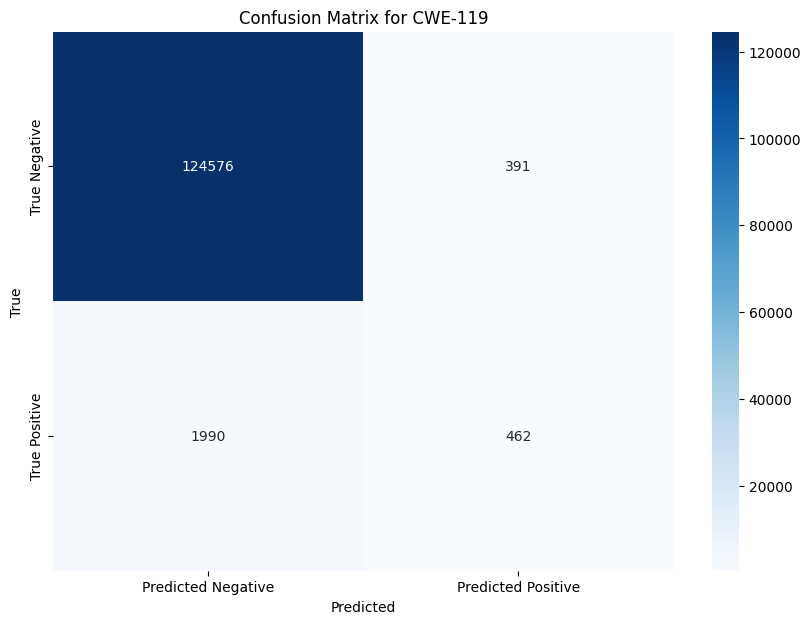

Accuracy for CWE-119: 0.9813
Precision for CWE-119: 0.5416
Recall for CWE-119: 0.1884
F1 Score for CWE-119: 0.2796


Confusion Matrix for Output CWE-120:
[[121931    597]
 [  4097    794]]


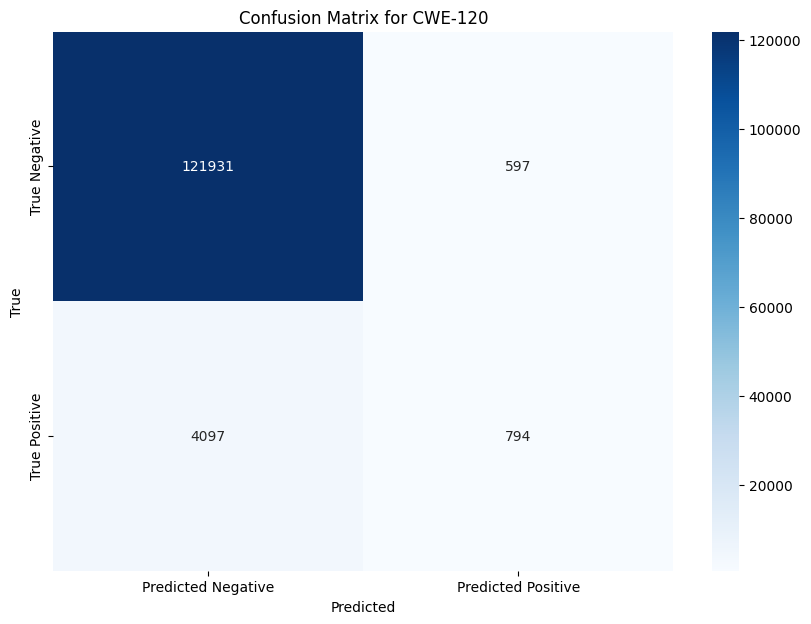

Accuracy for CWE-120: 0.9632
Precision for CWE-120: 0.5708
Recall for CWE-120: 0.1623
F1 Score for CWE-120: 0.2528


Confusion Matrix for Output CWE-469:
[[127141      0]
 [   278      0]]


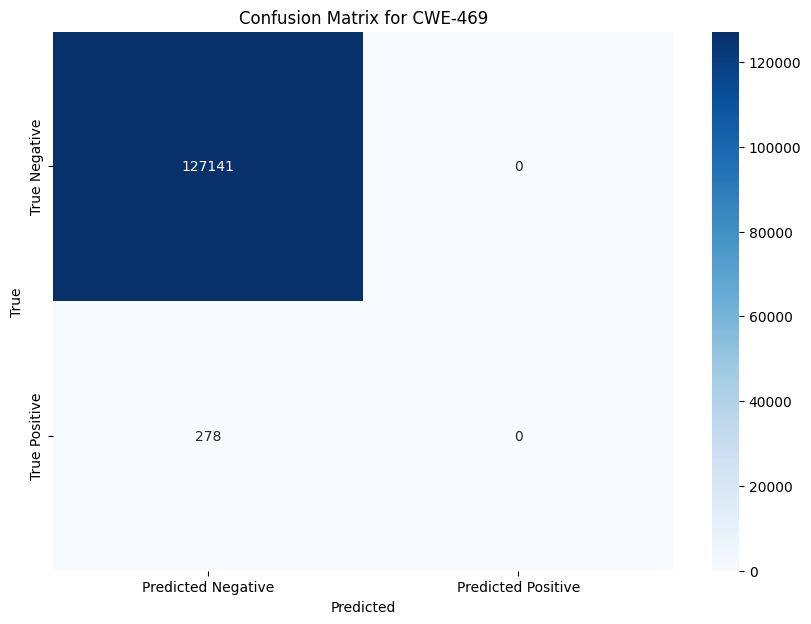

Accuracy for CWE-469: 0.9978
Precision for CWE-469: 0.0000
Recall for CWE-469: 0.0000
F1 Score for CWE-469: 0.0000


Confusion Matrix for Output CWE-476:
[[126111    116]
 [   931    261]]


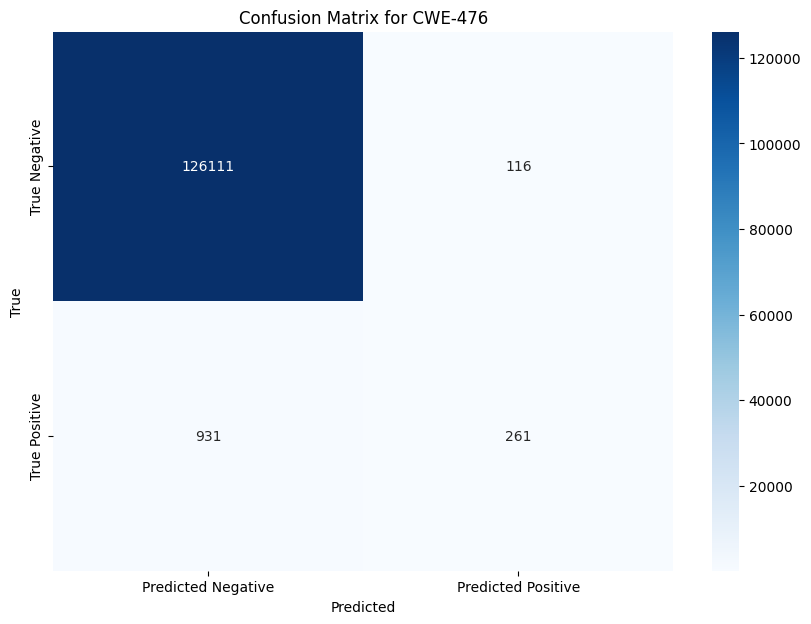

Accuracy for CWE-476: 0.9918
Precision for CWE-476: 0.6923
Recall for CWE-476: 0.2190
F1 Score for CWE-476: 0.3327


Confusion Matrix for Output CWE-other:
[[123303    626]
 [  2895    595]]


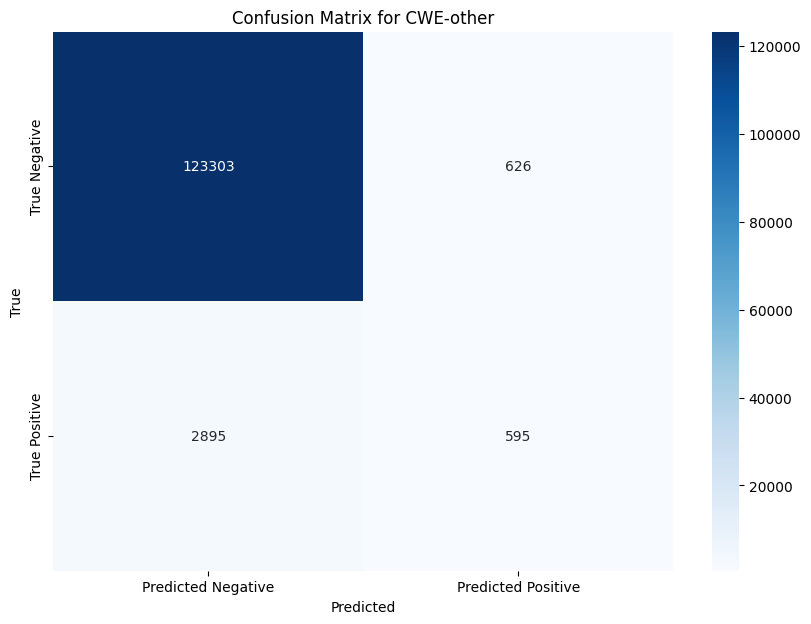

Accuracy for CWE-other: 0.9724
Precision for CWE-other: 0.4873
Recall for CWE-other: 0.1705
F1 Score for CWE-other: 0.2526


Output CWE-119:
Accuracy: 0.9813
Precision: 0.5416
Recall: 0.1884
F1 Score: 0.2796


Output CWE-120:
Accuracy: 0.9632
Precision: 0.5708
Recall: 0.1623
F1 Score: 0.2528


Output CWE-469:
Accuracy: 0.9978
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Output CWE-476:
Accuracy: 0.9918
Precision: 0.6923
Recall: 0.2190
F1 Score: 0.3327


Output CWE-other:
Accuracy: 0.9724
Precision: 0.4873
Recall: 0.1705
F1 Score: 0.2526




In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Converti le predizioni in label per ogni output
predicted_labels = [np.argmax(pred, axis=1) for pred in predicted]
y_test_labels = [np.argmax(y, axis=1) for y in y_test]

# Lista per le metriche di valutazione
accuracies = []
precisions = []
recalls = []
f1_scores = []

# 2. Calcola e visualizza la matrice di confusione per ogni output
for i in range(len(predicted_labels)):
    conf_matrix = confusion_matrix(y_test_labels[i], predicted_labels[i])

    # Stampa la matrice di confusione
    print(f"Confusion Matrix for Output {label_columns[i]}:")
    print(conf_matrix)

    # Plot della matrice di confusione
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label_columns[i]}')
    plt.show()

    # Estrai TN, FP, FN, TP dalla matrice di confusione
    TN, FP, FN, TP = conf_matrix.ravel()

    # Calcola le metriche di valutazione specifiche
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Aggiungi le metriche alla lista
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Stampa le metriche
    print(f"Accuracy for {label_columns[i]}: {accuracy:.4f}")
    print(f"Precision for {label_columns[i]}: {precision:.4f}")
    print(f"Recall for {label_columns[i]}: {recall:.4f}")
    print(f"F1 Score for {label_columns[i]}: {f1:.4f}")
    print("\n")

# Stampa le metriche complessive
for i in range(len(accuracies)):
    print(f"Output {label_columns[i]}:")
    print(f"Accuracy: {accuracies[i]:.4f}")
    print(f"Precision: {precisions[i]:.4f}")
    print(f"Recall: {recalls[i]:.4f}")
    print(f"F1 Score: {f1_scores[i]:.4f}")
    print("\n")

#🧠 Model - sigmoid CNN

In [ ]:
check_path_CNN = '/content/drive/My Drive/Sicurezza_approfondimento/CNN-sigmoid/Best_Model/best_CNN_unimb.h5'

## New class label

In [ ]:
train['not_vulnerable'] = (~(train[label_columns].any(axis=1))).astype(int)
validate['not_vulnerable'] = (~(validate[label_columns].any(axis=1))).astype(int)
test['not_vulnerable'] = (~(test[label_columns].any(axis=1))).astype(int)

In [ ]:
train

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other,not_vulnerable
0,"clear_area(int startx, int starty, int xsize, ...",0,0,0,0,0,1
1,ReconstructDuList(Statement* head)\n{\n Sta...,0,0,0,0,0,1
2,free_speaker(void)\n{\n if(Lengths)\n ...,0,0,0,0,0,1
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,0,0,0,0,0,1
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",1,1,0,0,1,0
...,...,...,...,...,...,...,...
1019466,visitICmpInst(ICmpInst &I) {\n // We must cas...,0,0,0,0,0,1
1019467,path_node_delete_chain(path_node * head)\n{\n ...,0,0,0,0,0,1
1019468,addrconf6_start (NMDevice *self)\n{\n\tNMDevic...,0,0,0,0,0,1
1019469,"Next(const SQObjectPtr &refpos, SQObjectPtr &o...",0,0,0,0,0,1


In [ ]:
label_columns = ['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other', 'not_vulnerable']

y_train = train[label_columns]
y_val= validate[label_columns]
y_test= test[label_columns]

In [ ]:
# Calcola le frequenze delle classi
class_freq = train[label_columns].sum(axis=0)

# Calcola i pesi come l'inverso delle frequenze
class_weights = 1 / class_freq

# Normalizza i pesi in modo che la loro somma sia 1
class_weights = class_weights / np.sum(class_weights)

# Map class labels to numerical indices
class_indices = {label: i for i, label in enumerate(y_train.columns)}  # Assuming y_train is a DataFrame

# Convert class_weights to use numerical indices
class_weights_numeric = {class_indices[label]: weight for label, weight in class_weights.items()}

# Print the class weights
print(class_weights_numeric)

{0: 0.07455731862841458, 1: 0.03782089079322453, 2: 0.6863543900084027, 3: 0.14833014721143012, 4: 0.05142932318994255, 5: 0.001507930168585536}


## Model

In [ ]:
random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [ ]:
# Must use non-sequential model building to create branches in the output layer
inp_layer = Input(shape=(INPUT_SIZE,))
embedding_layer = Embedding(input_dim = WORDS_SIZE,
                       output_dim = 13,
                       weights=[random_weights],
                       input_length = INPUT_SIZE)(inp_layer)
x = Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(embedding_layer)
x = MaxPool1D(pool_size=5)(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

# Output layer with sigmoid activation
output = Dense(6, activation='sigmoid', name = 'output')(x)

# Define the model
model_my_cnn = Model(inputs=inp_layer, outputs=output)

model_my_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 13)           130000    
                                                                 
 conv1d (Conv1D)             (None, 200, 512)          60416     
                                                                 
 max_pooling1d (MaxPooling1  (None, 40, 512)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                             

In [ ]:
## Compile model with metrics
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False)

## Compile model with metrics
model_my_cnn.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', precision_metric, recall_metric])

## Training

In [ ]:
checkpoint = ModelCheckpoint(check_path_CNN, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="auto", restore_best_weights=True, start_from_epoch=2,
)
callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Convert y_train and y_val to NumPy arrays
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

In [ ]:
history = model_my_cnn.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = 1024,
    epochs = 40,
    callbacks = callbacks_list,
    class_weight = class_weights_numeric
    )

Epoch 1/40
996/996 [==============================] - ETA: 0s - loss: 384.8292 - accuracy: 0.0544 - precision: 0.1600 - recall: 0.4902
Epoch 1: val_loss improved from inf to 11.21245, saving model to /content/drive/My Drive/Sicurezza_approfondimento/CNN-undersampling/Best_Model/best_CNN_unimb.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


996/996 [==============================] - 147s 145ms/step - loss: 384.8292 - accuracy: 0.0544 - precision: 0.1600 - recall: 0.4902 - val_loss: 11.2125 - val_accuracy: 0.4735 - val_precision: 0.5104 - val_recall: 0.0212
Epoch 2/40
996/996 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.1710 - precision: 0.2415 - recall: 0.3157
Epoch 2: val_loss did not improve from 11.21245
996/996 [==============================] - 108s 109ms/step - loss: 0.1147 - accuracy: 0.1710 - precision: 0.2415 - recall: 0.3157 - val_loss: 35.4968 - val_accuracy: 0.0182 - val_precision: 0.1311 - val_recall: 0.0017
Epoch 3/40
996/996 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.1818 - precision: 0.2461 - recall: 0.3176
Epoch 3: val_loss improved from 11.21245 to 9.92565, saving model to /content/drive/My Drive/Sicurezza_approfondimento/CNN-undersampling/Best_Model/best_CNN_unimb.h5
996/996 [==============================] - 98s 98ms/step - loss: 0.1285 - accuracy

## Test

In [ ]:
model_cnn = tf.keras.models.load_model("/content/drive/My Drive/Sicurezza_approfondimento/CNN-sigmoid/Best_Model/best_CNN_unimb.h5")

In [ ]:
predicted = model_cnn.predict(x_test)

3982/3982 [==============================] - 15s 4ms/step


In [ ]:
from sklearn.metrics import classification_report

binary_predictions = (predicted > 0.5).astype(int)
print(classification_report(y_test, binary_predictions, target_names=label_columns))

                precision    recall  f1-score   support

       CWE-119       0.00      0.00      0.00      2452
       CWE-120       0.00      0.00      0.00      4891
       CWE-469       0.00      0.00      0.00       278
       CWE-476       0.00      0.00      0.00      1192
     CWE-other       0.08      0.47      0.14      3490
not_vulnerable       0.97      0.56      0.71    119166

     micro avg       0.77      0.52      0.62    131469
     macro avg       0.18      0.17      0.14    131469
  weighted avg       0.88      0.52      0.65    131469
   samples avg       0.53      0.54      0.53    131469



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


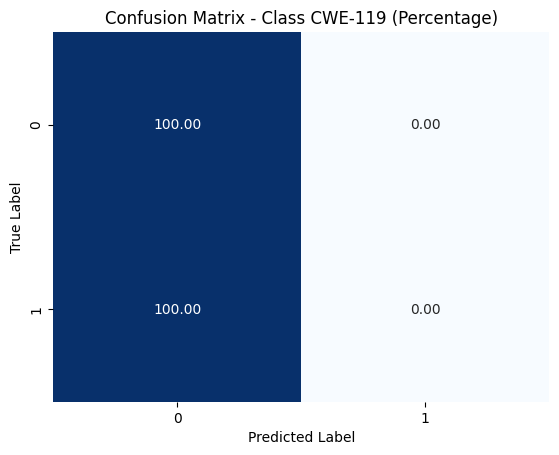

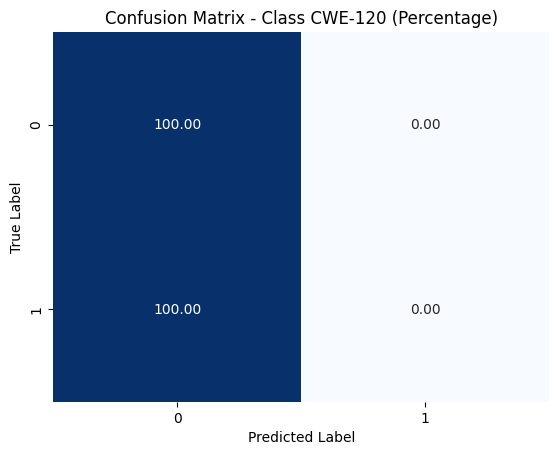

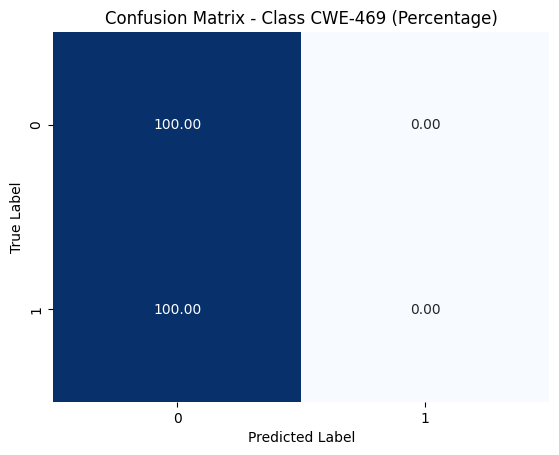

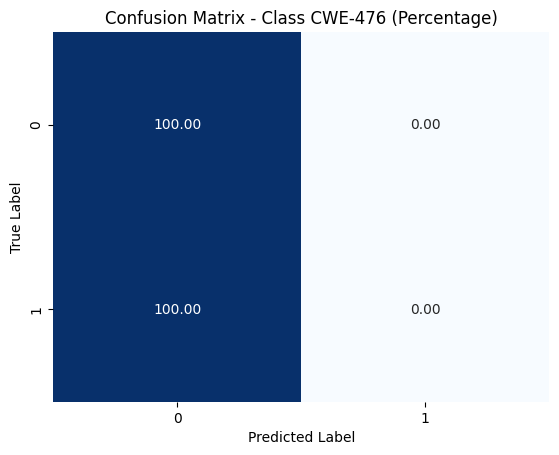

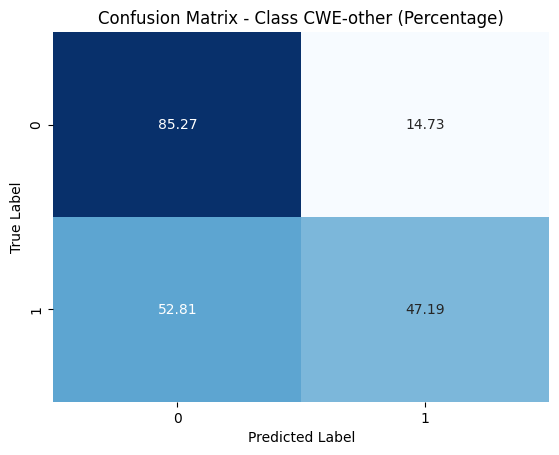

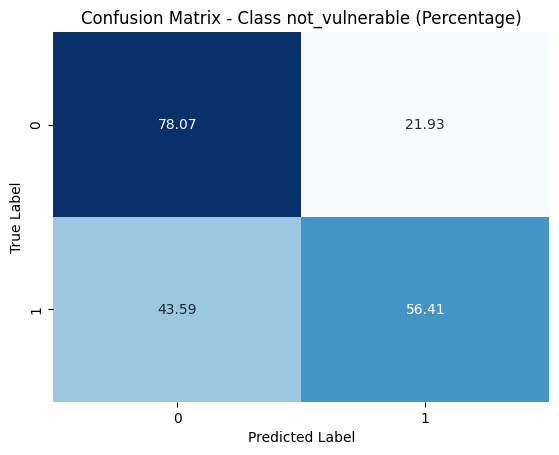

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
conf_matrix = multilabel_confusion_matrix(y_test, binary_predictions)

for i, matrix in enumerate(conf_matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)

    # Normalize the confusion matrix to get percentages
    matrix = matrix / row_sums.astype(float) * 100 if row_sums.any() else matrix

    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Class {label_columns[i]} (Percentage)")
    plt.show()

#🧠 Model - undersampling sigmoid CNN

In [ ]:
check_path_CNN = '/content/drive/My Drive/Sicurezza_approfondimento/CNN-undersampling-sigmoid/Best_Model/best_CNN_unimb.h5'

## Underampling train

In [ ]:
# Identifica le righe non vulnerabili
non_vulnerable_rows = train[(train['CWE-119'] == 0) &
                            (train['CWE-120'] == 0) &
                            (train['CWE-469'] == 0) &
                            (train['CWE-476'] == 0) &
                            (train['CWE-other'] == 0)]

# Identifica le righe non vulnerabili
vulnerable_rows = train[
    (train['CWE-119'] == 1) |
    (train['CWE-120'] == 1) |
    (train['CWE-469'] == 1) |
    (train['CWE-476'] == 1) |
    (train['CWE-other'] == 1)]

In [ ]:
num_non_vulnerable = non_vulnerable_rows.shape[0]
num_vulnerable = train.shape[0] - num_non_vulnerable
print("Number of non vulnerable code = ", num_non_vulnerable)
print("Number of vulnerable code = ", num_vulnerable)

# Scegli quanti esempi mantenere per la classe non vulnerabile (ad esempio, puoi scegliere di mantenere lo stesso numero di esempi della classe vulnerabile)
desired_num_non_vulnerable = num_vulnerable * 2

undersampled_non_vulnerable = non_vulnerable_rows.sample(n=desired_num_non_vulnerable, random_state=42)

# Identifica le righe vulnerabili
balanced_train = pd.concat([undersampled_non_vulnerable, vulnerable_rows])

Number of non vulnerable code =  953567
Number of vulnerable code =  65904


In [ ]:
# Scegli quanti esempi mantenere per la classe non vulnerabile (ad esempio, puoi scegliere di mantenere lo stesso numero di esempi della classe vulnerabile)
desired_num_non_vulnerable = num_vulnerable * 4

undersampled_non_vulnerable = non_vulnerable_rows.sample(n=desired_num_non_vulnerable, random_state=42)

# Identifica le righe vulnerabili
balanced_train = pd.concat([undersampled_non_vulnerable, vulnerable_rows])

In [ ]:
balanced_train

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
310417,"simplify_test_exp_in_temp (rtx exp, int insn_c...",0,0,0,0,0
276255,"httpSetGroupAcl(HttpAuth *auth, cchar *group, ...",0,0,0,0,0
685430,App(QWidget *parent)\n : KXmlGuiWindow(pare...,0,0,0,0,0
650477,"param_index_by_name(char *name, struct iscsi_k...",0,0,0,0,0
519225,REAL(ch)\n int ch;\n{\n DOUBLE temp;\n \n b...,0,0,0,0,0
...,...,...,...,...,...,...
1019364,GetNoDataValue( int *pbSuccess )\n\n{\n if(...,0,0,0,1,0
1019390,"thread_interrupt (DebuggerTlsData *tls, MonoTh...",0,1,0,0,0
1019424,newsnntp_mode_reader(newsnntp * f)\n{\n char ...,1,1,0,0,0
1019429,netsys_reshape(value bv)\n{\n struct caml_b...,0,0,0,0,1


## New class label

In [ ]:
balanced_train['not_vulnerable'] = (~(balanced_train[label_columns].any(axis=1))).astype(int)
validate['not_vulnerable'] = (~(validate[label_columns].any(axis=1))).astype(int)
test['not_vulnerable'] = (~(test[label_columns].any(axis=1))).astype(int)

In [ ]:
balanced_train

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other,not_vulnerable
310417,"simplify_test_exp_in_temp (rtx exp, int insn_c...",0,0,0,0,0,1
276255,"httpSetGroupAcl(HttpAuth *auth, cchar *group, ...",0,0,0,0,0,1
685430,App(QWidget *parent)\n : KXmlGuiWindow(pare...,0,0,0,0,0,1
650477,"param_index_by_name(char *name, struct iscsi_k...",0,0,0,0,0,1
519225,REAL(ch)\n int ch;\n{\n DOUBLE temp;\n \n b...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1019364,GetNoDataValue( int *pbSuccess )\n\n{\n if(...,0,0,0,1,0,0
1019390,"thread_interrupt (DebuggerTlsData *tls, MonoTh...",0,1,0,0,0,0
1019424,newsnntp_mode_reader(newsnntp * f)\n{\n char ...,1,1,0,0,0,0
1019429,netsys_reshape(value bv)\n{\n struct caml_b...,0,0,0,0,1,0


In [ ]:
label_columns = ['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other', 'not_vulnerable']

y_balanced_train = balanced_train[label_columns]
y_val= validate[label_columns]
y_test= test[label_columns]

In [ ]:
# Calcola le frequenze delle classi
class_freq = balanced_train[label_columns].sum(axis=0)

# Calcola i pesi come l'inverso delle frequenze
class_weights = 1 / class_freq

# Normalizza i pesi in modo che la loro somma sia 1
class_weights = class_weights / np.sum(class_weights)

# Map class labels to numerical indices
class_indices = {label: i for i, label in enumerate(y_balanced_train.columns)}  # Assuming y_balanced_train is a DataFrame

# Convert class_weights to use numerical indices
class_weights_numeric = {class_indices[label]: weight for label, weight in class_weights.items()}

# Print the class weights
print(class_weights_numeric)

{0: 0.07426422433556298, 1: 0.03767221206595828, 2: 0.6836562436924428, 3: 0.14774704255577345, 4: 0.05122714798582452, 5: 0.0054331293644379235}


## Sequence 500

In [ ]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(balanced_train['functionSource']))

## Tokkenizing train data and create matrix
balanced_train_sequences = tokenizer.texts_to_sequences(balanced_train['functionSource'])
x_balanced_train = pad_sequences(balanced_train_sequences, maxlen=500, padding='post')
x_balanced_train = x_balanced_train.astype(np.int64)

In [ ]:
x_val = np.load('/content/drive/My Drive/Sicurezza_approfondimento/OSF/x_val_full_500.npy')
x_test = np.load('/content/drive/My Drive/Sicurezza_approfondimento/OSF/x_test_full_500.npy')

## Model

In [ ]:
random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [ ]:
# Must use non-sequential model building to create branches in the output layer
inp_layer = Input(shape=(500,), name='input_layer')
embedding_layer = Embedding(input_dim = WORDS_SIZE,
                       output_dim = 13,
                       weights=[random_weights],
                       input_length = INPUT_SIZE,
                       name='embedding_layer')(inp_layer)
x = Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu', name='convolution_layer')(embedding_layer)
x = MaxPool1D(pool_size=5, name='MaxPool1DLayer')(x)
x = Dropout(0.5, name='dropout_layer')(x)
x = Flatten( name='flatten_layer')(x)
x = Dense(64, activation='relu', name='dense_32_layer')(x)
x = Dense(16, activation='relu', name='dense_16_layer')(x)

# Output layer with sigmoid activation
output = Dense(6, activation='sigmoid', name = 'output')(x)

# Define the model
model_my_cnn = Model(inputs=inp_layer, outputs=output)

model_my_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 500)]             0         
                                                                 
 embedding_layer (Embedding  (None, 500, 13)           130000    
 )                                                               
                                                                 
 convolution_layer (Conv1D)  (None, 500, 512)          60416     
                                                                 
 MaxPool1DLayer (MaxPooling  (None, 100, 512)          0         
 1D)                                                             
                                                                 
 dropout_layer (Dropout)     (None, 100, 512)          0         
                                                                 
 flatten_layer (Flatten)     (None, 51200)             0   

In [ ]:
## Compile model with metrics
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False)

## Compile model with metrics
model_my_cnn.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', precision_metric, recall_metric])

## Training

In [ ]:
checkpoint = ModelCheckpoint(check_path_CNN, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="auto", restore_best_weights=True, start_from_epoch=2)
callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Convert y_train and y_val to NumPy arrays
y_balanced_train = y_balanced_train.to_numpy()
y_val = y_val.to_numpy()

In [ ]:
history = model_my_cnn.fit(
    x = x_balanced_train,
    y = y_balanced_train,
    validation_data = (x_val, y_val),
    batch_size = 1024,
    epochs = 40,
    callbacks = callbacks_list,
    class_weight = class_weights_numeric
    )

Epoch 1/40
322/322 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.4296 - precision: 0.5432 - recall: 0.1883
Epoch 1: val_loss improved from inf to 0.45564, saving model to /content/drive/My Drive/Sicurezza_approfondimento/CNN-undersampling-sigmoid/Best_Model/best_CNN_unimb.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


322/322 [==============================] - 103s 290ms/step - loss: 0.0089 - accuracy: 0.4296 - precision: 0.5432 - recall: 0.1883 - val_loss: 0.4556 - val_accuracy: 0.4402 - val_precision: 0.3555 - val_recall: 0.1966
Epoch 2/40
322/322 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.6064 - precision: 0.6611 - recall: 0.5436
Epoch 2: val_loss improved from 0.45564 to 0.39684, saving model to /content/drive/My Drive/Sicurezza_approfondimento/CNN-undersampling-sigmoid/Best_Model/best_CNN_unimb.h5
322/322 [==============================] - 90s 278ms/step - loss: 0.0067 - accuracy: 0.6064 - precision: 0.6611 - recall: 0.5436 - val_loss: 0.3968 - val_accuracy: 0.5932 - val_precision: 0.5428 - val_recall: 0.4608
Epoch 3/40
322/322 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.6342 - precision: 0.6743 - recall: 0.5987
Epoch 3: val_loss did not improve from 0.39684
322/322 [==============================] - 82s 253ms/step - loss: 0.0059 - accura

## Test

In [ ]:
model_my_cnn = tf.keras.models.load_model("/content/drive/My Drive/Sicurezza_approfondimento/CNN-undersampling-sigmoid/Best_Model/best_CNN_unimb.h5")

In [ ]:
predicted = model_my_cnn.predict(x_test)

3982/3982 [==============================] - 14s 3ms/step


In [ ]:
from sklearn.metrics import classification_report

binary_predictions = (predicted > 0.5).astype(int)
print(classification_report(y_test, binary_predictions, target_names=label_columns))

                precision    recall  f1-score   support

       CWE-119       0.03      0.07      0.04      2452
       CWE-120       0.06      0.21      0.09      4891
       CWE-469       0.01      0.05      0.02       278
       CWE-476       0.02      0.11      0.03      1192
     CWE-other       0.04      0.14      0.06      3490
not_vulnerable       0.95      0.63      0.76    119166

     micro avg       0.61      0.59      0.60    131469
     macro avg       0.18      0.20      0.17    131469
  weighted avg       0.86      0.59      0.69    131469
   samples avg       0.60      0.60      0.60    131469



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


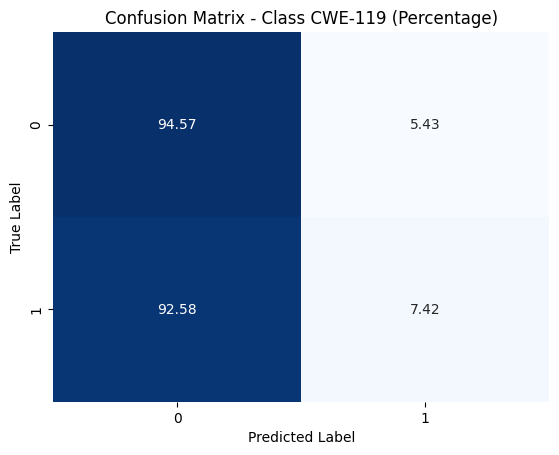

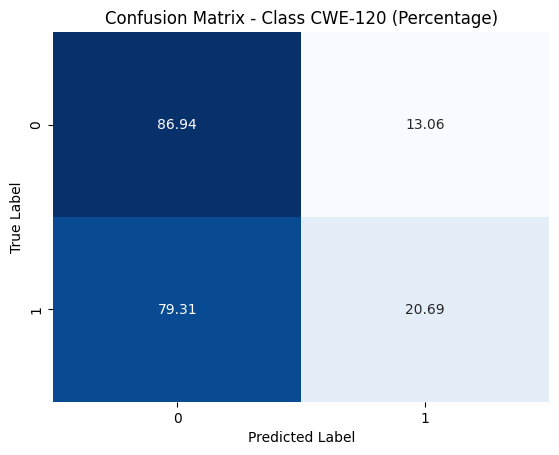

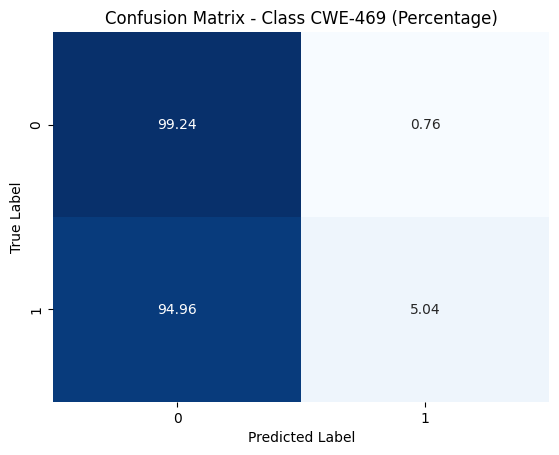

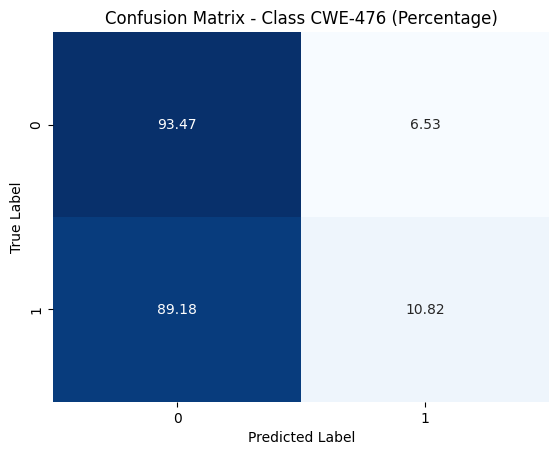

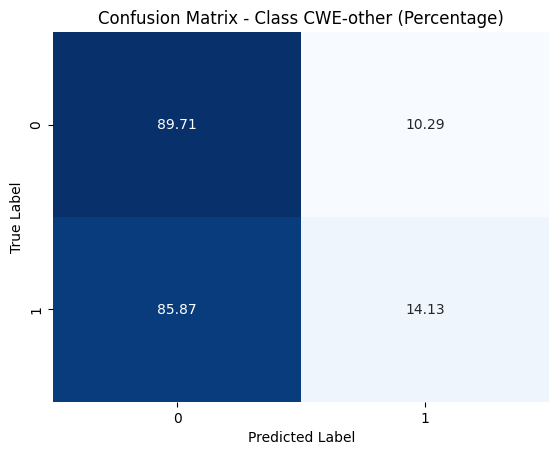

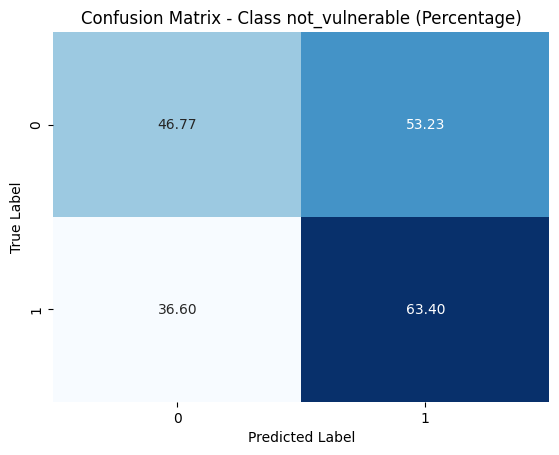

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
conf_matrix = multilabel_confusion_matrix(y_test, binary_predictions)

for i, matrix in enumerate(conf_matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)

    # Normalize the confusion matrix to get percentages
    matrix = matrix / row_sums.astype(float) * 100 if row_sums.any() else matrix

    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Class {label_columns[i]} (Percentage)")
    plt.show()

#🧠 Model - RNN

In [ ]:
check_path_RNN = '/content/drive/My Drive/Sicurezza_approfondimento/Model/RNN/Best_Model/best_RNN_unimb.h5'

## Underampling train

In [ ]:
# Identifica le righe non vulnerabili
non_vulnerable_rows = train[(train['CWE-119'] == 0) &
                            (train['CWE-120'] == 0) &
                            (train['CWE-469'] == 0) &
                            (train['CWE-476'] == 0) &
                            (train['CWE-other'] == 0)]

# Identifica le righe non vulnerabili
vulnerable_rows = train[
    (train['CWE-119'] == 1) |
    (train['CWE-120'] == 1) |
    (train['CWE-469'] == 1) |
    (train['CWE-476'] == 1) |
    (train['CWE-other'] == 1)]

In [ ]:
num_non_vulnerable = non_vulnerable_rows.shape[0]
num_vulnerable = train.shape[0] - num_non_vulnerable
print("Number of non vulnerable code = ", num_non_vulnerable)
print("Number of vulnerable code = ", num_vulnerable)

# Scegli quanti esempi mantenere per la classe non vulnerabile (ad esempio, puoi scegliere di mantenere lo stesso numero di esempi della classe vulnerabile)
desired_num_non_vulnerable = num_vulnerable * 2

undersampled_non_vulnerable = non_vulnerable_rows.sample(n=desired_num_non_vulnerable, random_state=42)

# Identifica le righe vulnerabili
balanced_train = pd.concat([undersampled_non_vulnerable, vulnerable_rows])

Number of non vulnerable code =  953567
Number of vulnerable code =  65904


In [ ]:
balanced_train

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
310417,"simplify_test_exp_in_temp (rtx exp, int insn_c...",0,0,0,0,0
276255,"httpSetGroupAcl(HttpAuth *auth, cchar *group, ...",0,0,0,0,0
685430,App(QWidget *parent)\n : KXmlGuiWindow(pare...,0,0,0,0,0
650477,"param_index_by_name(char *name, struct iscsi_k...",0,0,0,0,0
519225,REAL(ch)\n int ch;\n{\n DOUBLE temp;\n \n b...,0,0,0,0,0
...,...,...,...,...,...,...
1019364,GetNoDataValue( int *pbSuccess )\n\n{\n if(...,0,0,0,1,0
1019390,"thread_interrupt (DebuggerTlsData *tls, MonoTh...",0,1,0,0,0
1019424,newsnntp_mode_reader(newsnntp * f)\n{\n char ...,1,1,0,0,0
1019429,netsys_reshape(value bv)\n{\n struct caml_b...,0,0,0,0,1


## New class label

In [ ]:
balanced_train['not_vulnerable'] = (~(balanced_train[label_columns].any(axis=1))).astype(int)
validate['not_vulnerable'] = (~(validate[label_columns].any(axis=1))).astype(int)
test['not_vulnerable'] = (~(test[label_columns].any(axis=1))).astype(int)

In [ ]:
balanced_train

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other,not_vulnerable
310417,"simplify_test_exp_in_temp (rtx exp, int insn_c...",0,0,0,0,0,1
276255,"httpSetGroupAcl(HttpAuth *auth, cchar *group, ...",0,0,0,0,0,1
685430,App(QWidget *parent)\n : KXmlGuiWindow(pare...,0,0,0,0,0,1
650477,"param_index_by_name(char *name, struct iscsi_k...",0,0,0,0,0,1
519225,REAL(ch)\n int ch;\n{\n DOUBLE temp;\n \n b...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1019364,GetNoDataValue( int *pbSuccess )\n\n{\n if(...,0,0,0,1,0,0
1019390,"thread_interrupt (DebuggerTlsData *tls, MonoTh...",0,1,0,0,0,0
1019424,newsnntp_mode_reader(newsnntp * f)\n{\n char ...,1,1,0,0,0,0
1019429,netsys_reshape(value bv)\n{\n struct caml_b...,0,0,0,0,1,0


In [ ]:
label_columns = ['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other', 'not_vulnerable']

y_balanced_train = balanced_train[label_columns]
y_val= validate[label_columns]
y_test= test[label_columns]

In [ ]:
# Calcola le frequenze delle classi
class_freq = balanced_train[label_columns].sum(axis=0)

# Calcola i pesi come l'inverso delle frequenze
class_weights = 1 / class_freq

# Normalizza i pesi in modo che la loro somma sia 1
class_weights = class_weights / np.sum(class_weights)

# Map class labels to numerical indices
class_indices = {label: i for i, label in enumerate(y_balanced_train.columns)}  # Assuming y_balanced_train is a DataFrame

# Convert class_weights to use numerical indices
class_weights_numeric = {class_indices[label]: weight for label, weight in class_weights.items()}

# Print the class weights
print(class_weights_numeric)

{0: 0.07386291754928291, 1: 0.03746864009720061, 2: 0.6799619226040431, 3: 0.14694865152212402, 4: 0.05095032826122073, 5: 0.010807539966128538}


## Sequence 500

In [ ]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(balanced_train['functionSource']))

## Tokkenizing train data and create matrix
balanced_train_sequences = tokenizer.texts_to_sequences(balanced_train['functionSource'])
x_balanced_train = pad_sequences(balanced_train_sequences, maxlen=500, padding='post')
x_balanced_train = x_balanced_train.astype(np.int64)

In [ ]:
x_val = np.load('/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/x_val_full_500.npy')
x_test = np.load('/content/drive/My Drive/Sicurezza_approfondimento/dataset/VDISC/x_test_full_500.npy')

## Model

In [ ]:
inp = Input(shape=(500, ), name = 'input_layer')

embedding_layer = Embedding(input_dim = WORDS_SIZE,
                            output_dim = 32,
                            name ='embedding_layer')(inp)

x = SpatialDropout1D(0.5, name='spatial_dropout')(embedding_layer)
x = Bidirectional(LSTM(128, return_sequences=False, dropout = 0.5, name='lstm_layer'))(x)
x = Dropout(0.5, name = 'dropout_layer')(x)
x = Dense(64, activation="relu", name = 'dense_layer')(x)
x = Dropout(0.5, name = 'dropout_layer_2')(x)

output = Dense(6, activation='sigmoid', name = 'output')(x)

model_rnn = Model(inputs=inp, outputs = output)
model_rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 500)]             0         
                                                                 
 embedding_layer (Embedding  (None, 500, 32)           320000    
 )                                                               
                                                                 
 spatial_dropout (SpatialDr  (None, 500, 32)           0         
 opout1D)                                                        
                                                                 
 bidirectional (Bidirection  (None, 256)               164864    
 al)                                                             
                                                                 
 dropout_layer (Dropout)     (None, 256)               0         
                                                             

In [ ]:
model_rnn.compile(optimizer = keras.optimizers.Adam(),
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy', precision_metric, recall_metric])

## Training

In [ ]:
checkpoint = ModelCheckpoint(check_path_RNN, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, mode="auto", restore_best_weights=True, start_from_epoch=2)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Convert y_train and y_val to NumPy arrays
y_balanced_train = y_balanced_train.to_numpy()
y_val = y_val.to_numpy()

In [ ]:
history = model_rnn.fit(
    x = x_balanced_train,
    y = y_balanced_train,
    validation_data = (x_val, y_val),
    batch_size = 1024,
    epochs = 40,
    callbacks = callbacks_list,
    class_weight = class_weights_numeric
    )

import pickle
with open('/content/drive/My Drive/Sicurezza_approfondimento/Model/RNN/Best_Model/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/40
194/194 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.2315 - precision: 0.3251 - recall: 0.1023
Epoch 1: val_loss improved from inf to 0.41745, saving model to /content/drive/My Drive/Sicurezza_approfondimento/Model/RNN/Best_Model/best_RNN_unimb.h5
194/194 [==============================] - 87s 399ms/step - loss: 0.0168 - accuracy: 0.2315 - precision: 0.3251 - recall: 0.1023 - val_loss: 0.4175 - val_accuracy: 0.2341 - val_precision: 0.0359 - val_recall: 0.0065
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


194/194 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.3654 - precision: 0.4143 - recall: 0.1688
Epoch 2: val_loss did not improve from 0.41745
194/194 [==============================] - 83s 428ms/step - loss: 0.0146 - accuracy: 0.3654 - precision: 0.4143 - recall: 0.1688 - val_loss: 0.4388 - val_accuracy: 0.5303 - val_precision: 0.0383 - val_recall: 0.0112
Epoch 3/40
194/194 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.4790 - precision: 0.5240 - recall: 0.2680
Epoch 3: val_loss did not improve from 0.41745
194/194 [==============================] - 81s 418ms/step - loss: 0.0138 - accuracy: 0.4790 - precision: 0.5240 - recall: 0.2680 - val_loss: 0.4255 - val_accuracy: 0.4785 - val_precision: 0.3133 - val_recall: 0.1455
Epoch 4/40
194/194 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.5100 - precision: 0.6062 - recall: 0.3990
Epoch 4: val_loss did not improve from 0.41745
194/194 [==============================

## Test

In [ ]:
model_rnn = tf.keras.models.load_model("/content/drive/My Drive/Sicurezza_approfondimento/Model/RNN/Best_Model/best_RNN_unimb.h5")

In [ ]:
predicted = model_rnn.predict(x_test)

3982/3982 [==============================] - 62s 15ms/step


In [ ]:
from sklearn.metrics import classification_report

binary_predictions = (predicted > 0.5).astype(int)
print(classification_report(y_test, binary_predictions, target_names=label_columns))

                precision    recall  f1-score   support

       CWE-119       0.02      0.06      0.03      2452
       CWE-120       0.06      0.23      0.09      4891
       CWE-469       0.00      0.00      0.00       278
       CWE-476       0.02      0.09      0.03      1192
     CWE-other       0.04      0.05      0.04      3490
not_vulnerable       0.95      0.58      0.72    119166

     micro avg       0.63      0.54      0.58    131469
     macro avg       0.18      0.17      0.15    131469
  weighted avg       0.86      0.54      0.66    131469
   samples avg       0.55      0.55      0.55    131469



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


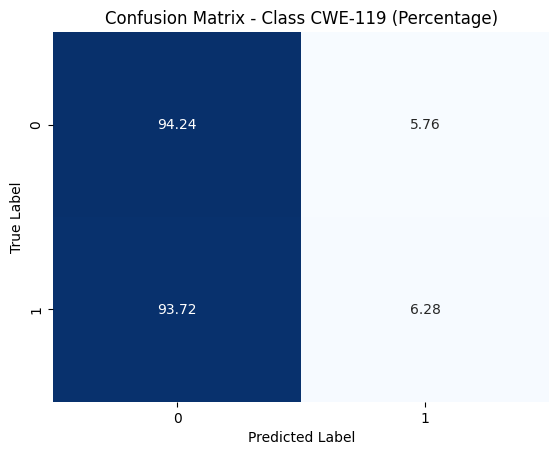

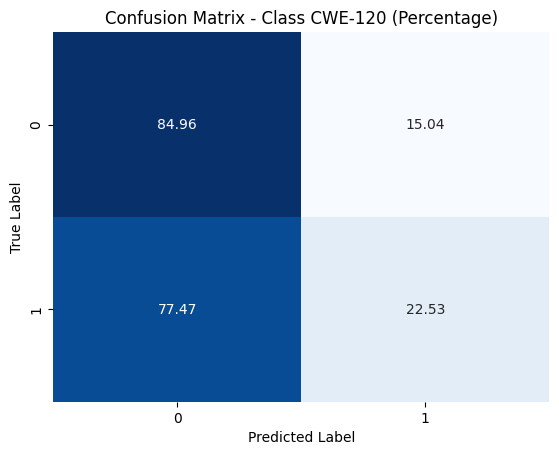

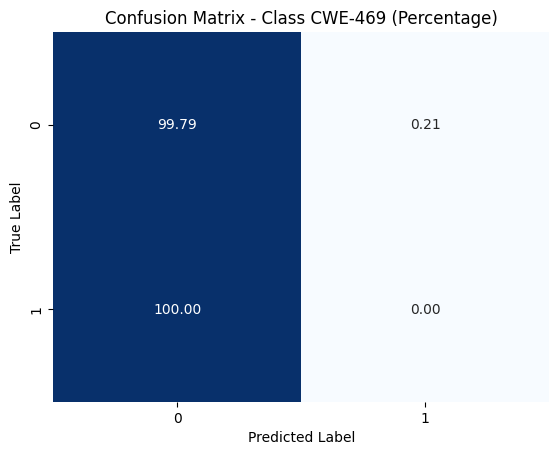

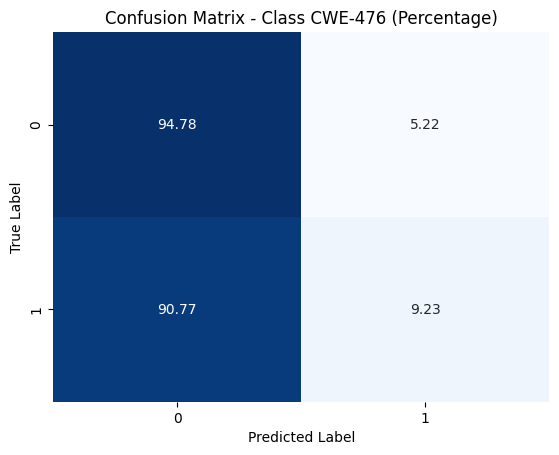

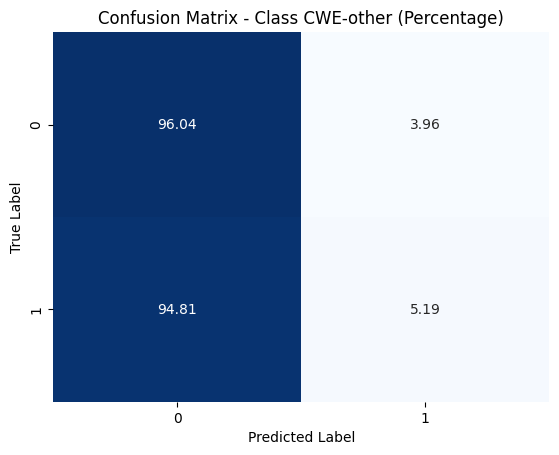

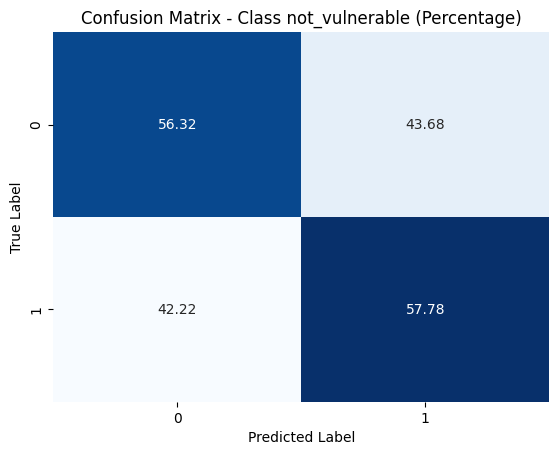

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
conf_matrix = multilabel_confusion_matrix(y_test, binary_predictions)

for i, matrix in enumerate(conf_matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)

    # Normalize the confusion matrix to get percentages
    matrix = matrix / row_sums.astype(float) * 100 if row_sums.any() else matrix

    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Class {label_columns[i]} (Percentage)")
    plt.show()

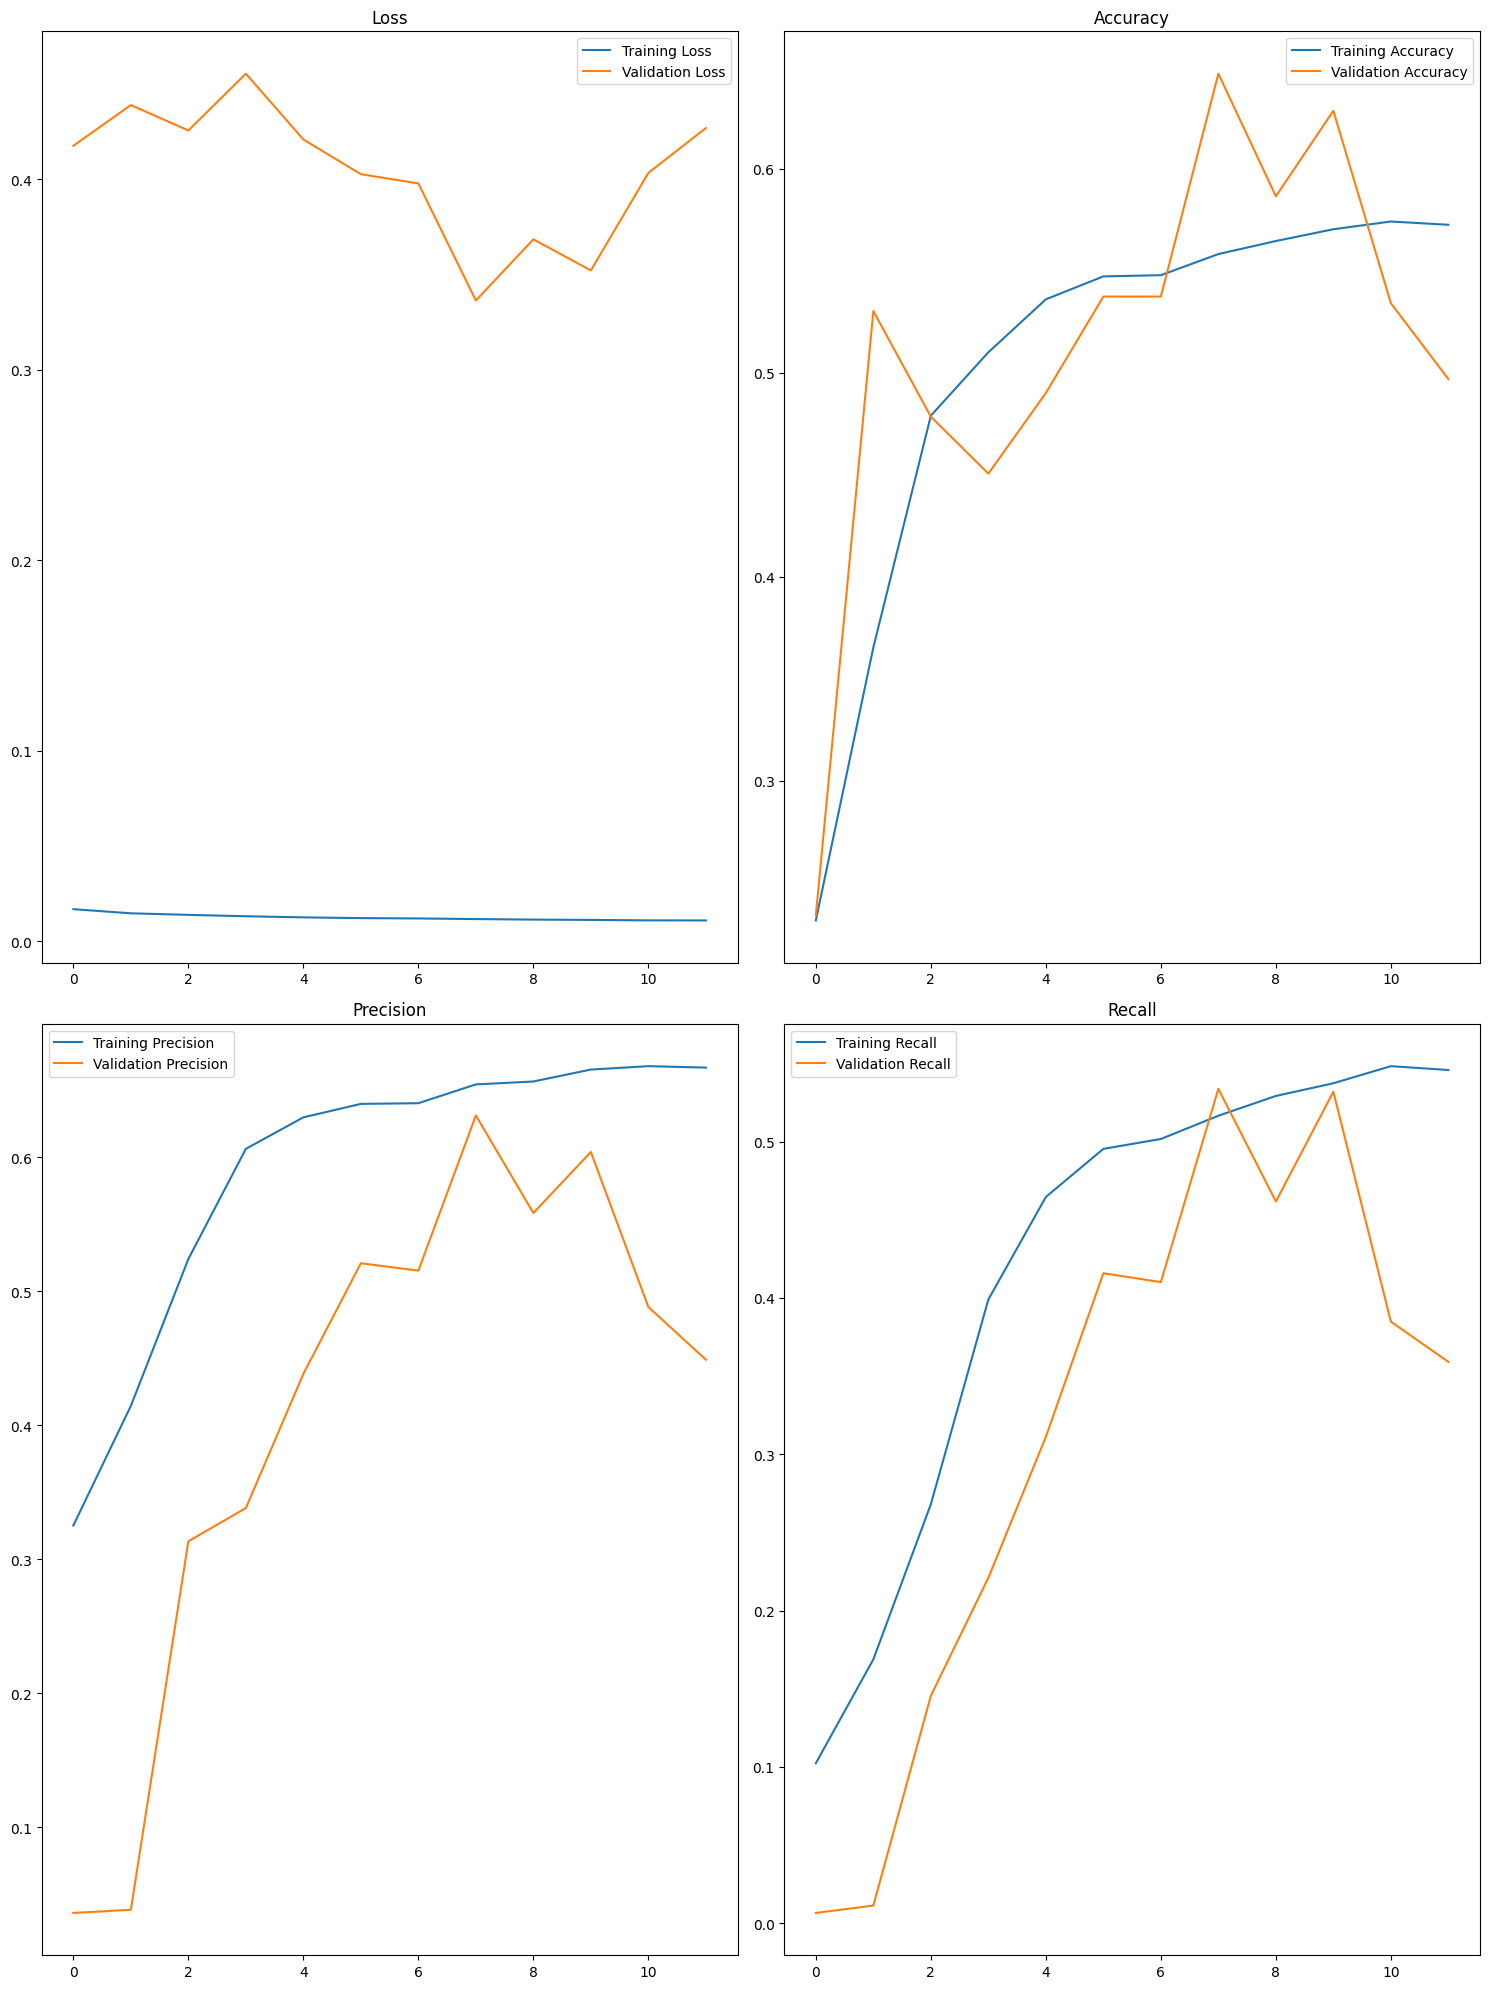

In [ ]:
import matplotlib.pyplot as plt

# Creiamo una figura
plt.figure(figsize=(15, 20))

# Grafico per la loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Grafico per l'accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Grafico per la precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.legend()

# Grafico per il recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.legend()

# Mostriamo la figura
plt.tight_layout()
plt.show()